# Test the endpoint

In [1]:
import json, os, sys, re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.huggingface.model import HuggingFaceModel
from sagemaker.workflow.model_step import ModelStep
from sagemaker.workflow.pipeline_context import PipelineSession

from src.utils import config

In [4]:
client = boto3.client('sagemaker-runtime')

session = sagemaker.Session()
default_bucket = session.default_bucket()

iam = boto3.client('iam')
role_arn = iam.get_role(RoleName=f'101436505502-sagemaker-exec')['Role']['Arn']

# load local csv
df = pd.read_csv("data/mtsamples.csv")
df = df[df["transcription"].notna()]
df.reset_index(drop=True, inplace=True)

## Run Inference on deployed endpoint

In [5]:
# get random sample
n_samples = 100
idx = np.random.randint(len(df), size=n_samples)
inputs = df.loc[idx].transcription.tolist()
targets = df.loc[idx].medical_specialty.tolist()

# for t, i in zip(targets, inputs):
#     text_block = re.sub("(.{120})", "\\1\n", i, 0, re.DOTALL)
#     print(f"'{t}': \n {text_block[:500]} ... \n")

In [6]:
endpoint_name = "2-2023-04-18-12-29-54-071"
CONTENT_TYPE_JSON = "application/json"
payload = json.dumps({"instances":inputs})

response = client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType=CONTENT_TYPE_JSON,
    Accept=CONTENT_TYPE_JSON,
    Body=payload,
)

prediction = json.loads(response["Body"].read())["prediction"]

results = pd.DataFrame()
results["pred"] = prediction
results["target"] = targets
results["correct"] = results.apply(lambda x: x.pred == x.target, axis=1)
results

,pred,target,correct
0,Surgery,Dentistry,False
1,Consult - History and Phy.,Consult - History and Phy.,True
2,Consult - History and Phy.,SOAP / Chart / Progress Notes,False
3,Surgery,Pediatrics - Neonatal,False
4,Consult - History and Phy.,Consult - History and Phy.,True
...,...,...,...
95,Surgery,Cardiovascular / Pulmonary,False
96,Consult - History and Phy.,Neurology,False
97,Radiology,Nephrology,False
98,Surgery,Ophthalmology,False


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


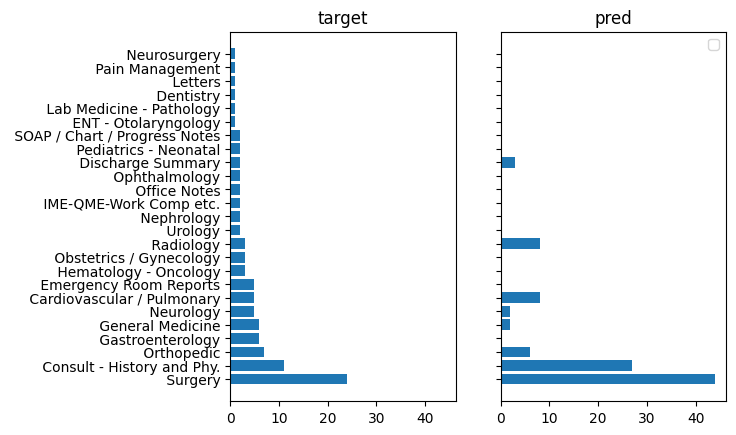

In [23]:
counts_tar = results['target'].value_counts()
counts_pred = results['pred'].value_counts()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)
# plot the counts as a bar chart
ax1.barh(counts_tar.index, counts_tar.values)
ax1.set_title('target')
ax2.barh(counts_pred.index, counts_pred.values)
ax2.set_title('pred')

plt.legend()
plt.show()

<AxesSubplot:>

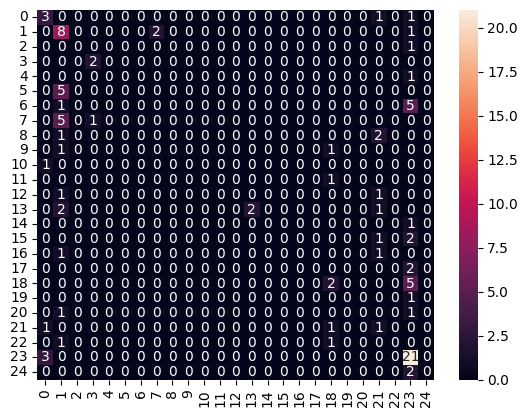

In [47]:
confusion_matrix = pd.crosstab(results['target'], results['pred'],)
i = confusion_matrix.index.union(confusion_matrix.columns)
confusion_matrix = confusion_matrix.reindex(index=i, columns=i, fill_value=0)
sn.heatmap(confusion_matrix.to_numpy(), annot=True)

In [25]:
import seaborn as sn

# Get new model (only for testing model inference code)
Use model data from trained model

In [22]:
gpu_instance_type = "ml.g4dn.xlarge"
pytorch_version = "1.9.0"
transformers_version = "4.11.0"
py_version = "py38"

model = HuggingFaceModel(
    name="text-classification-model-123",
    model_data="s3://sagemaker-eu-west-3-101436505502/model/pipelines-kam521dashky-train-model-JzSCBl76CF/output/model.tar.gz",
    sagemaker_session=session,
    source_dir="src",
    entry_point="model.py",
    dependencies=['requirements.txt'],
    role=role_arn,
    transformers_version=transformers_version,
    pytorch_version=pytorch_version,
    py_version=py_version,
)

## Run batch inference (Transformer)
Use latest approved model from model registry

In [155]:
def get_latest_approved_model(model_package_group_name):
    """Retrieves the latest approved model from a given SageMaker model package group."""
    sm_client = boto3.client('sagemaker')
    df = pd.DataFrame(sm_client.list_model_packages(
        ModelPackageGroupName=model_package_group_name)["ModelPackageSummaryList"])
    model_package_ arns = sm_client.list_model_packages(
        ModelPackageGroupName=model_package_group_name)["ModelPackageSummaryList"]
    asdasd
    try:
        model_package_arn = df.loc[df.ModelApprovalStatus ==
                                   "Approved"].iloc[0].ModelPackageArn
        print(f"The latest approved model-arn is: {model_package_arn}")
        return model_package_arn

    except IndexError:
        raise SystemExit(
            f"There is no approved model in the model-group '{model_package_group_name}'")
        
        
get_latest_approved_model("training-pipelineModelGroup")

[{'ModelPackageGroupName': 'training-pipelineModelGroup', 'ModelPackageVersion': 1, 'ModelPackageArn': 'arn:aws:sagemaker:eu-west-3:101436505502:model-package/training-pipelinemodelgroup/1', 'CreationTime': datetime.datetime(2023, 4, 14, 15, 50, 32, 258000, tzinfo=tzlocal()), 'ModelPackageStatus': 'Completed', 'ModelApprovalStatus': 'Approved'}]
The latest approved model-arn is: arn:aws:sagemaker:eu-west-3:101436505502:model-package/training-pipelinemodelgroup/1


'arn:aws:sagemaker:eu-west-3:101436505502:model-package/training-pipelinemodelgroup/1'

In [101]:
def get_latest_approved_model(model_package_group_name):
    """Retrieves the latest approved model from a given SageMaker model package group."""
    sm_client = boto3.client('sagemaker')
    df = pd.DataFrame(sm_client.list_model_packages(
        ModelPackageGroupName=model_package_group_name)["ModelPackageSummaryList"])
    model_package_arn = df.loc[df.ModelApprovalStatus ==
                               "Approved"].iloc[0].ModelPackageArn
    print(f"The latest approved model-arn is: {model_package_arn}")
    return sagemaker.ModelPackage(role=role_arn, model_package_arn=model_package_arn, sagemaker_session=session)


def run_batch_inference(input_data_path, output_data_path):
    CONTENT_TYPE_CSV = 'text/csv'
    CONTENT_TYPE_JSON = "application/json"

    model = get_latest_approved_model("training-pipelineModelGroup")
    transformer = model.transformer(
        instance_count=1,
        instance_type='ml.g4dn.xlarge',  # "ml.m5.large"
        output_path=output_data_path,
        accept=CONTENT_TYPE_CSV,
        # strategy = 'SingleRecord',
        # assemble_with = 'Line',
    )

    transformer.transform(
        data=input_data_path,
        content_type=CONTENT_TYPE_CSV,
        # split_type='Line',
    )
    transformer.wait()


In [102]:
input_data_path = f"s3://{default_bucket}/data/test.csv"
output_data_path = f"s3://{default_bucket}/data/out"

run_batch_inference(input_data_path, output_data_path)

The latest approved model-arn is: arn:aws:sagemaker:eu-west-3:101436505502:model-package/training-pipelinemodelgroup/52


# Torch test area

In [27]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm


class MyTokenizer:
    def __init__(self, model_name="distilbert-base-uncased") -> None:
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)

    def tokenize(self, txt_input):
        return self.tokenizer.encode(txt_input, padding="max_length", truncation=True)
    
    
model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=40,
    )


class MyDataset(Dataset):
    def __init__(self, x, y) -> None:
        self.x = torch.tensor(x)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [17]:
tok = MyTokenizer()
texts = list(df.transcription.values)

inputs = tok.tokenizer(texts, padding="max_length", return_tensors='pt', truncation=True)
inputs

{'input_ids': tensor([[  101, 20714,  1024,  ...,     0,     0,     0],
        [  101,  2627,  2966,  ...,  1010, 26572,   102],
        [  101,  2381,  1997,  ...,  4645,  2545,   102],
        ...,
        [  101, 20714,  1024,  ...,  8048,  1999,   102],
        [  101,  2708, 12087,  ..., 27179,  1024,   102],
        [  101,  2381,  1024,  ..., 17758,  2135,   102]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

In [22]:
dataset = MyDataset(inputs.input_ids, inputs.attention_mask)

dataloader = DataLoader(dataset, shuffle=False, batch_size=10)


/var/folders/b8/mx2blhp93k7blwkppkkv1w_r0000gn/T/ipykernel_9997/2213946952.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x)
/var/folders/b8/mx2blhp93k7blwkppkkv1w_r0000gn/T/ipykernel_9997/2213946952.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y)


In [32]:
output = []
for (x, _) in tqdm(list(enumerate(dataloader))[:4]):
    outs = model(x)
    output += torch.argmax(outs.logits.cpu(), dim=1)

print(output)

  0%|          | 0/4 [00:00<?, ?it/s]


AttributeError: 'int' object has no attribute 'size'

# Manage Sagemaker resource

In [ ]:
from sagemaker.experiments.experiment import _Experiment

experiment_name = "q9lp5qy5wd0f-tune-mo-8zsgutfsto"
exp = _Experiment.load(experiment_name=experiment_name, sagemaker_session=sagemaker.Session())
exp._delete_all(action="--force")

# sm = boto3.Session().client('sagemaker')
# sm.delete_experiment(ExperimentName=experiment_name)

def empty_and_delete_model_package(sagemaker_client, mpg_name):
    mpg = sagemaker_client.list_model_packages(
        ModelPackageGroupName=mpg_name,
    )
    
    # Delete model packages if Group not empty
    model_packages = mpg.get('ModelPackageSummaryList')
    if model_packages:
        for mp in model_packages:
            sagemaker_client.delete_model_package(
                ModelPackageName=mp['ModelPackageArn']
            )
            time.sleep(1)

    # Delete model package group
    sagemaker_client.delete_model_package_group(
        ModelPackageGroupName=mpg_name
    )
    
    
    
import time

client = boto3.client(service_name='sagemaker')
mpg_name='training-pipelineModelGroup'

empty_and_delete_model_package(client, mpg_name)


import boto3

search_params={
   # "MaxResults": 10,
   "Resource": "ExperimentTrial",
#    "SearchExpression": { 
#       "Filters": [{ 
#             "Name": "Tags.Project",
#             "Operator": "Equals",
#             "Value": "Project_Binary_Classifier"
#          }]},
#   "SortBy": "Trail.CreationTime",
  "SortOrder": "Ascending"
}

smclient = boto3.client(service_name='sagemaker')
results = smclient.search(**search_params)
results
